In [1]:
from helpers import math_helper
from sensors.activpal import *
from utils import read_functions
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import statistics
import os

import matplotlib.pyplot as plt

Adnan Akbas
# Feature Extraction

In [2]:
activpal = Activpal()

features_columns = ['standard_deviation_x', 'mean_x', 'standard_deviation_y', 'mean_y','standard_deviation_z', 'mean_z', 'activiteit']
activity_columns = ['cycling_light','cycling_hard', 'activity_walking', 'activity_running', 'activity_jumping', 'activity_standing', 'activity_traplopen', 'activity_sitten']
activities = ['fietsen licht', 'fietsen zwaar', 'lopen', 'rennen', 'springen', 'staan', 'traplopen', 'zitten']
test_users = ['BMR032', 'BMR042', 'BMR098']
segment_size = 9.4

In [3]:
def extract_features_from_correspondent(correspondent):
    features_df = pd.DataFrame(columns=features_columns, index=pd.to_datetime([]))

    # Getting dataset for a correspodent
    activities_df = read_functions.read_activities(correspondent)
        
    for activity_name in activities:
        activity = activities_df.loc[activity_name]
        if not activity.empty:
            start_time = activity.start
            stop_time = activity.stop
            activpal_df = activpal.read_data(correspondent, start_time, stop_time)

            # denormalizing dataset
            activpal_df['x'] = math_helper.convert_value_to_g(activpal_df['pal_accX'])
            activpal_df['y'] = math_helper.convert_value_to_g(activpal_df['pal_accY'])
            activpal_df['z'] = math_helper.convert_value_to_g(activpal_df['pal_accZ'])

            date_range = pd.date_range(start_time, stop_time, freq=str(segment_size) + 'S')
            
            for time in date_range:
                segment_time = time + pd.DateOffset(seconds=segment_size)
                activpal_segment = activpal_df[(activpal_df.index >= time) & (activpal_df.index <= segment_time)]

                stdev_x =  statistics.stdev(activpal_segment['x']) if len(activpal_segment['x']) >= 2 else 0
                mean_x = activpal_segment['x'].mean()

                stdev_y =  statistics.stdev(activpal_segment['y']) if len(activpal_segment['y']) >= 2 else 0
                mean_y = activpal_segment['y'].mean()

                stdev_z =  statistics.stdev(activpal_segment['z']) if len(activpal_segment['z']) >= 2 else 0
                mean_z = activpal_segment['z'].mean()  


                features_df.loc[segment_time] = [stdev_x, mean_x, stdev_y, mean_y, stdev_z, mean_z, activity_name]

    return features_df

In [4]:
def extract_features_from_correspondents(correspodents):
    all_features_df = pd.DataFrame(index=pd.to_datetime([]))

    for correspodent in correspodents:
        print("Extracting " + correspodent)
        
        features_df     = extract_features_from_correspondent(correspodent)
        all_features_df = pd.concat([all_features_df, features_df])
    
    print("Done extracting features")

    return all_features_df

def extract_features_from_all_correspondents(exclude_test_correspodent = True):
    
    exclude = ['output', 'throughput', 'Test data','.ipynb_checkpoints', 'BRM015', 'BMR035', 'BMR100', 'BMR051', 'BMR027']
    
    if (exclude_test_correspodent):
        exclude = exclude + test_users
    
    correspodents = []
    
    for directory in os.walk('../../data'):
        if directory[0] == '../../data':
            correspodents = directory[1]
            
    for exclude_item in exclude:
        if exclude_item in correspodents:
            correspodents.remove(exclude_item)
        
    return extract_features_from_correspondents(correspodents)

In [5]:
features_dataset = extract_features_from_all_correspondents()

Extracting BMR099
Extracting BMR025
Extracting BMR060
Extracting BMR012
Extracting BMR030
Extracting BMR044
Extracting BMR043
Extracting BMR004
Extracting BMR011
Extracting BMR034
Extracting BMR014
Extracting BMR036
Extracting BMR052
Extracting BMR002
Extracting BMR031
Extracting BMR097
Extracting BMR008
Extracting BMR015
Extracting BMR033
Extracting BMR064
Extracting BMR055
Extracting BMR041
Extracting BMR053
Extracting BMR018
Extracting BMR058
Extracting BMR040
Done extracting features


# model preperation

In [6]:
features_dataset[activity_columns] = 0

features_dataset.loc[(features_dataset['activiteit'] == 'lopen'), 'activity_walking'] = 1
features_dataset.loc[(features_dataset['activiteit'] == 'rennen'), 'activity_running'] = 1
features_dataset.loc[(features_dataset['activiteit'] == 'springen'), 'activity_jumping'] = 1
features_dataset.loc[(features_dataset['activiteit'] == 'staan'), 'activity_standing'] = 1
features_dataset.loc[(features_dataset['activiteit'] == 'traplopen'), 'activity_traplopen'] = 1
features_dataset.loc[(features_dataset['activiteit'] == 'zitten'), 'activity_sitten'] = 1
features_dataset.loc[(features_dataset['activiteit'] == 'fietsen licht'), 'cycling_light'] = 1
features_dataset.loc[(features_dataset['activiteit'] == 'fietsen zwaar'), 'cycling_hard'] = 1

features_dataset.drop('activiteit', axis=1, inplace=True)
features_dataset.dropna(how='any', inplace=True)

## Preparing feature dataset for learning
### Splitting in x and y

In [7]:
x = features_dataset[features_columns[:-1]]
y = features_dataset[activity_columns]

train_x, valid_x, train_y, valid_y = train_test_split(x,y, test_size=0.2, random_state=23, stratify=y)

# Random tree forest

In [8]:
ftc = RandomForestClassifier(n_estimators=287, random_state=0)
ftc.fit(train_x, train_y)

RandomForestClassifier(n_estimators=287, random_state=0)

##  Validation result

In [9]:
prediction_y = ftc.predict(valid_x)

#### Accuracy

In [10]:
accuracy_score(valid_y, prediction_y, normalize=True)

0.923578751164958

#### Classification report 

In [11]:
print(classification_report(valid_y,prediction_y, target_names=activity_columns, zero_division=0))

                    precision    recall  f1-score   support

     cycling_light       0.89      0.91      0.90       167
      cycling_hard       0.91      0.89      0.90       166
  activity_walking       0.94      0.95      0.94       170
  activity_running       0.98      0.95      0.97       168
  activity_jumping       0.96      0.76      0.85        34
 activity_standing       0.95      0.98      0.96       166
activity_traplopen       0.95      0.58      0.72        36
   activity_sitten       0.99      0.98      0.98       166

         micro avg       0.94      0.92      0.93      1073
         macro avg       0.95      0.87      0.90      1073
      weighted avg       0.95      0.92      0.93      1073
       samples avg       0.92      0.92      0.92      1073



### Confusion matrix

Text(69.0, 0.5, 'true label')

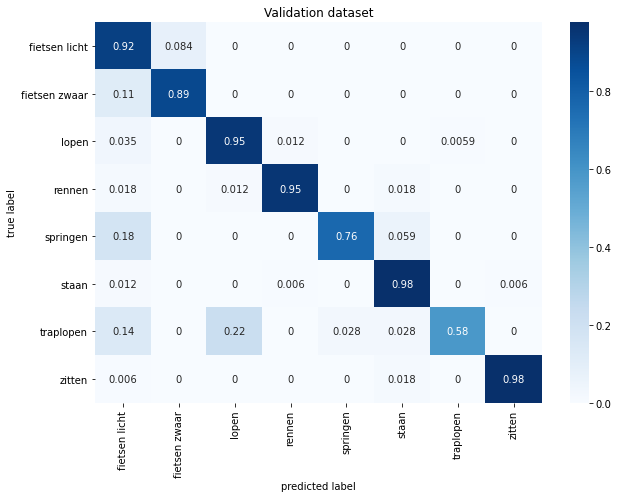

In [12]:
import seaborn as sn

#confusion_matrix(valid_y, prediction_y)
cm = confusion_matrix(valid_y.values.argmax(axis=1), prediction_y.argmax(axis=1), normalize='true')

df_cm = pd.DataFrame(cm, index=activities, columns=activities)
df_cm.head()
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues')

plt.title("Validation dataset")
plt.xlabel("predicted label")
plt.ylabel("true label")

## Test result

In [13]:
test_dataset = extract_features_from_correspondents(test_users)

test_dataset[activity_columns] = 0

test_dataset.loc[(test_dataset['activiteit'] == 'lopen'), 'activity_walking'] = 1
test_dataset.loc[(test_dataset['activiteit'] == 'rennen'), 'activity_running'] = 1
test_dataset.loc[(test_dataset['activiteit'] == 'springen'), 'activity_jumping'] = 1
test_dataset.loc[(test_dataset['activiteit'] == 'staan'), 'activity_standing'] = 1
test_dataset.loc[(test_dataset['activiteit'] == 'traplopen'), 'activity_traplopen'] = 1
test_dataset.loc[(test_dataset['activiteit'] == 'zitten'), 'activity_sitten'] = 1
test_dataset.loc[(test_dataset['activiteit'] == 'fietsen licht'), 'cycling_light'] = 1
test_dataset.loc[(test_dataset['activiteit'] == 'fietsen zwaar'), 'cycling_hard'] = 1

test_dataset.drop('activiteit', axis=1, inplace=True)
test_dataset.dropna(how='any', inplace=True)

x = test_dataset[features_columns[:-1]]
y = test_dataset[activity_columns]

Extracting BMR032
Extracting BMR042
Extracting BMR098
Done extracting features


In [14]:
test_prediction_y = ftc.predict(x)

In [16]:
accuracy_score(y, test_prediction_y, normalize=True)

0.7977346278317152

In [17]:
print(classification_report(y,test_prediction_y, target_names=activity_columns, zero_division=0))

                    precision    recall  f1-score   support

     cycling_light       0.71      0.59      0.65        96
      cycling_hard       0.64      0.70      0.67        96
  activity_walking       0.90      0.64      0.75        98
  activity_running       0.99      1.00      0.99        96
  activity_jumping       0.89      0.53      0.67        15
 activity_standing       1.00      0.98      0.99        96
activity_traplopen       0.93      0.52      0.67        25
   activity_sitten       1.00      0.99      0.99        96

         micro avg       0.87      0.80      0.83       618
         macro avg       0.88      0.74      0.80       618
      weighted avg       0.88      0.80      0.83       618
       samples avg       0.80      0.80      0.80       618

